In [1]:
from matplotlib import pyplot as plt
import networkx as nx
import pandas as pd
from rdflib import Graph, RDF, URIRef
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph

from viscars.data import DataLoader
from viscars.evaluation.evaluators.kfoldcv import KFoldCrossValidation
from viscars.evaluation.evaluators.loocv import LeaveOneOutCrossValidation
from viscars.evaluation.metrics import MetricType
from viscars.evaluation.metrics.factory import MetricFactory
from viscars.namespace import DASHB
from viscars.recommenders.factory import RecommenderFactory, RecommenderType
from viscars.utils import clean_graph, visualize_graph

In [2]:
project = 'proeftuin'

graph = Graph()
graph.parse(f'./data/{project}/graph.ttl', format='n3')
d_loader = DataLoader(graph)

metric_factory = MetricFactory()
recommender_factory = RecommenderFactory()

metrics = ['f1@1', 'ndcg@1', 'ndcg@3']
parsed_metrics = []
for metric in metrics:
    m_split = metric.split('@')
    m_type = m_split[0]
    n = int(m_split[1]) if len(m_split) >= 2 else None

    metric_ = metric_factory.get(MetricType.reverse_lookup(m_type), n)
    parsed_metrics.append(metric_)

In [3]:
recommender = recommender_factory.get(RecommenderType.PPR)(graph, alpha=0.3)
recommender.set_personalization(0.7, 0.3)

In [4]:
uid = ['https://dynamicdashboard.ilabt.imec.be/users/8']
cid = ['https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB4/properties/rpm%3A%3Anumber']

recommender.predict(uid, cid)

[{'contextId': ['https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB4/properties/rpm%3A%3Anumber'],
  'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/multiple-time-series-line-chart-with-time-range-selector'),
  'score': 0.0026366793693964555},
 {'contextId': ['https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB4/properties/rpm%3A%3Anumber'],
  'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/traditional-gauge'),
  'score': 0.0006004364220280027},
 {'contextId': ['https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB4/properties/rpm%3A%3Anumber'],
  'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/modern-gauge'),
  'score': 0.0005782171450988627},
 {'contextId': ['https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB4/properties/rpm%3A%3Anumber'],
  'itemId': rdflib.term.URIRef('http://localhost/web-thing-gate

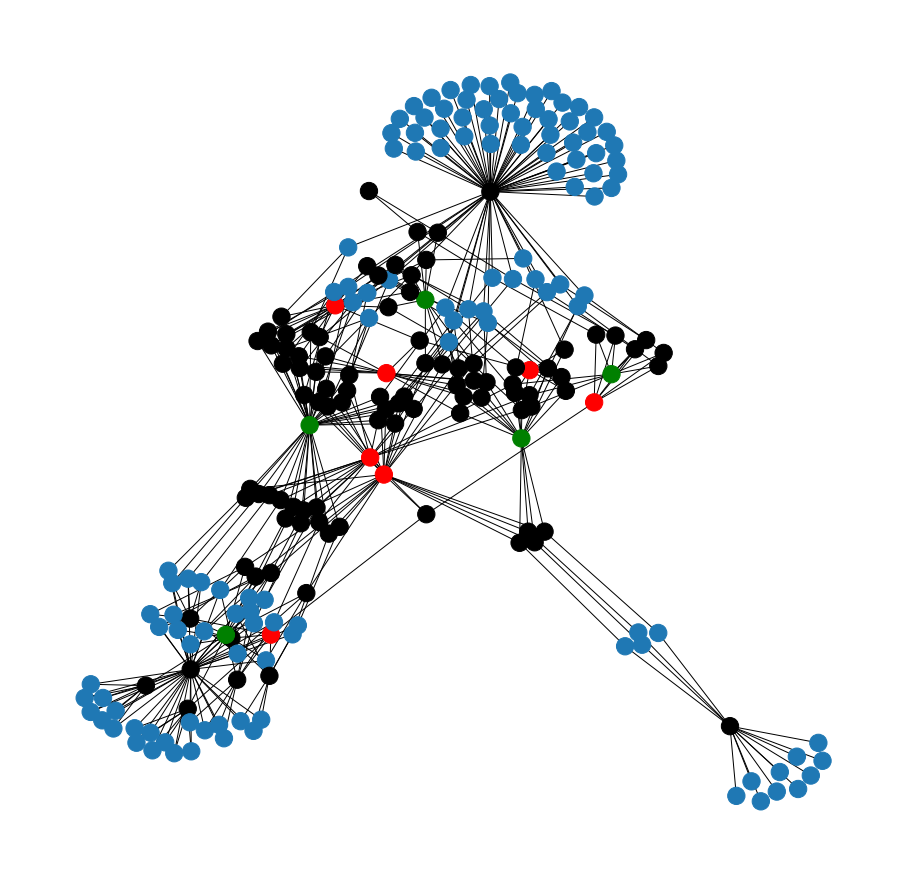

In [5]:
networkx_graph = rdflib_to_networkx_multidigraph(recommender.graph).to_undirected()
visualize_graph(clean_graph(d_loader.graph), colored=True)

In [14]:
from networkx.drawing.nx_agraph import graphviz_layout
    
def visualize_path(path: list, horizontal_layout: bool = False):
    """
    Visualize a path in the graph
    
    :param path: List of nodes in the graph
    """
    graph_ = nx.Graph()
    edges = [(path[idx], path[idx + 1]) for idx in range(len(path) - 1)]
    graph_.add_edges_from(edges)
    
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    
    pos = graphviz_layout(graph_, prog='dot', root=0)
    if horizontal_layout:
        pos = {node: (-y, x) for node, (x, y) in pos.items()}
    nx.draw(graph_, pos, with_labels=True, arrows=False, ax=ax)
    
    plt.show()


def visualize_graph_paths(paths: list, weighted: bool = False, colored: bool = True, horizontal_layout: bool = False):
    """
    Visualize a subgraph of multiple paths
    
    :param paths: List of paths
    """
    graph_ = nx.DiGraph()
    edges = []
    for path in paths:
        edges.extend([(path[idx], path[idx + 1]) for idx in range(len(path) - 1)])
    graph_.add_edges_from(edges)
    
    labels = {}
    for node in graph_.nodes:
        labels[node] = '/'.join(str(node).split('/')[-2:])
        
    colors = '#1f78b4'
    if colored:
        colors = []
        for node in graph_.nodes:
            color = '#1f78b4'
            if URIRef(node) in set(d_loader.context_metadata['id']):
                color = 'g'
            if URIRef(node) in set(d_loader.item_metadata['id']):
                color = 'r'
            if URIRef(node) in set(d_loader.user_metadata['id']):
                color = 'orange'
            colors.append(color)
    
    fig = plt.figure(figsize=(24, 6))
    ax = fig.add_subplot(111)

    pos = graphviz_layout(graph_, prog='dot', root=0)
    if horizontal_layout:
        pos = {node: (-y, x) for node, (x, y) in pos.items()}
    nx.draw(graph_, pos, with_labels=True, labels=labels, node_color=colors, arrows=False, ax=ax)
    
    plt.show()

# Shortest path (item --> user)

## Shortest path

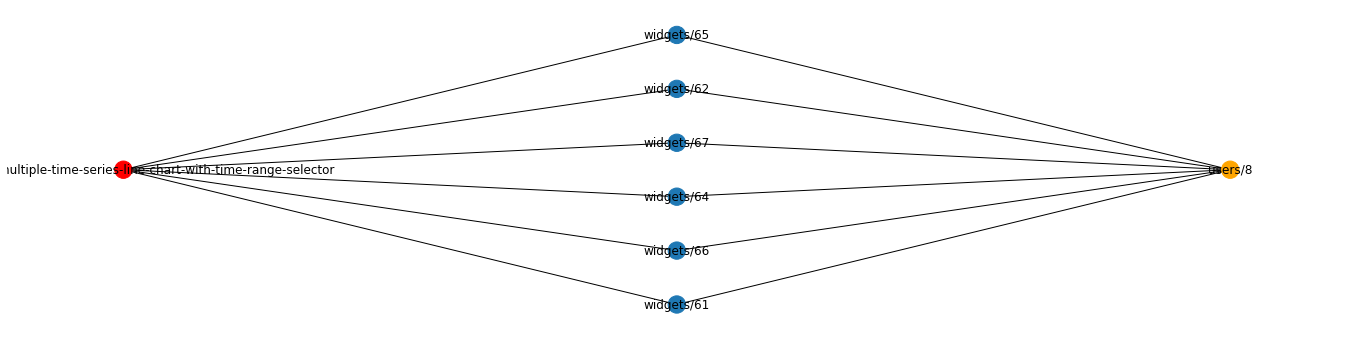

In [15]:
shortest_paths = list(nx.all_shortest_paths(networkx_graph, source=URIRef('http://localhost/web-thing-gateway/things/visualizations/multiple-time-series-line-chart-with-time-range-selector'), target=URIRef(uid[0])))

visualize_graph_paths(shortest_paths, horizontal_layout=True)

## Weighted shortest path

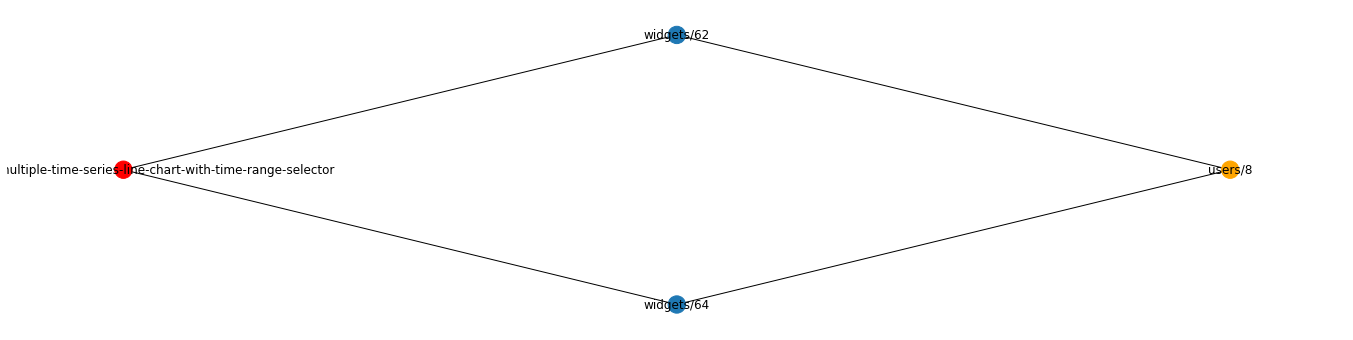

In [16]:
pr = recommender.run(uid, cid)

def get_edge_weight(source, target, edge):
    return pr[target]

# Method for weighted graph --> Requires reinitialization of graph object
# G.add_edge(x1, x2, weight=weight)
# nx.all_shortest_paths(G, weight='weight', method='dijkstra', source=None, target=None)

# Method is ignored if no weights are provided
shortest_paths_weighted = list(nx.all_shortest_paths(networkx_graph, weight=get_edge_weight, method='dijkstra', source=URIRef('http://localhost/web-thing-gateway/things/visualizations/multiple-time-series-line-chart-with-time-range-selector'), target=URIRef(uid[0])))
visualize_graph_paths(shortest_paths_weighted, weighted=True, horizontal_layout=True)

# Shortest path (item --> context)

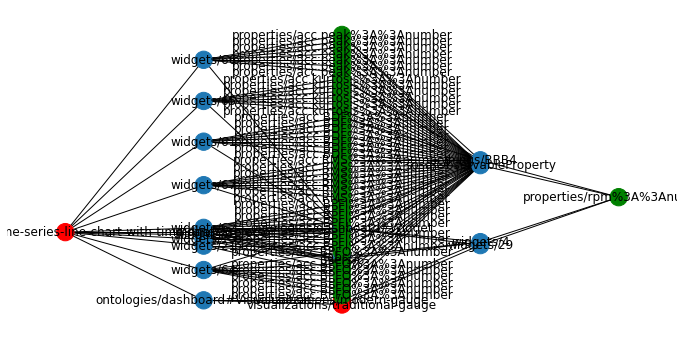

In [9]:
shortest_paths = list(nx.all_shortest_paths(networkx_graph, source=URIRef('http://localhost/web-thing-gateway/things/visualizations/multiple-time-series-line-chart-with-time-range-selector'), target=URIRef(cid[0])))

visualize_graph_paths(shortest_paths, horizontal_layout=True)

## Weighted

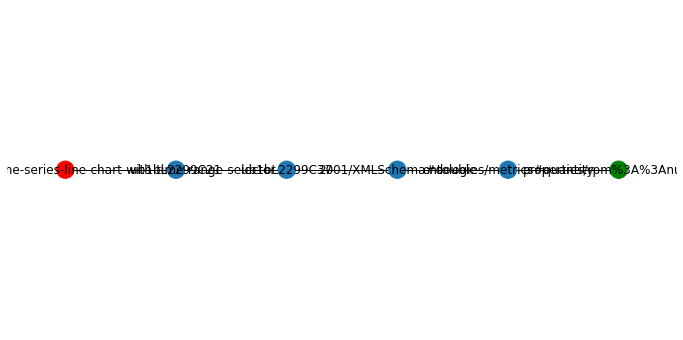

In [10]:
shortest_paths_weighted = list(nx.all_shortest_paths(networkx_graph, method='dijkstra', weight=get_edge_weight, source=URIRef('http://localhost/web-thing-gateway/things/visualizations/multiple-time-series-line-chart-with-time-range-selector'), target=URIRef(cid[0])))

visualize_graph_paths(shortest_paths_weighted, horizontal_layout=True)

# Extra (expected output --> user)

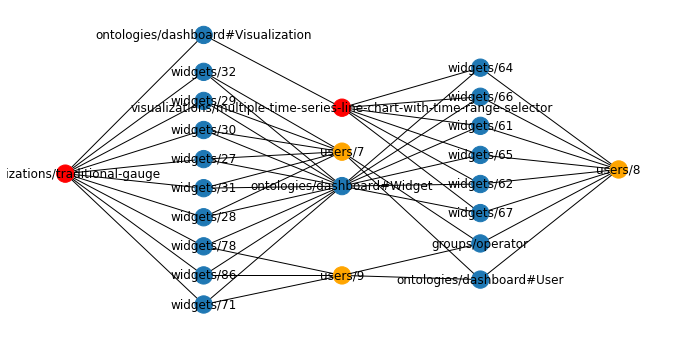

In [11]:
shortest_paths = list(nx.all_shortest_paths(networkx_graph, source=URIRef('http://localhost/web-thing-gateway/things/visualizations/traditional-gauge'), target=URIRef(uid[0])))

visualize_graph_paths(shortest_paths, horizontal_layout=True)

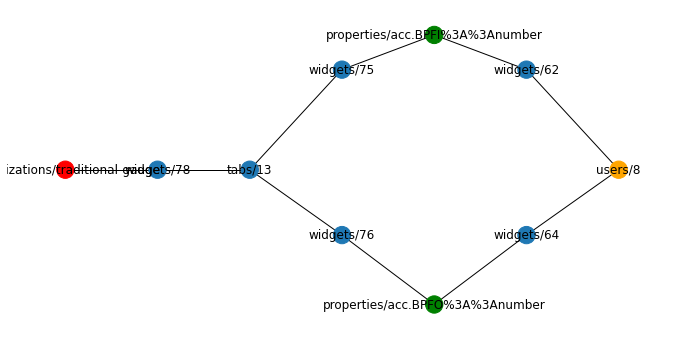

In [12]:
shortest_paths_weigthed = list(nx.all_shortest_paths(networkx_graph, method='dijkstra', weight=get_edge_weight, source=URIRef('http://localhost/web-thing-gateway/things/visualizations/traditional-gauge'), target=URIRef(uid[0])))

visualize_graph_paths(shortest_paths_weigthed, horizontal_layout=True)

### Subgraph

In [13]:
nodes = nx.single_source_shortest_path_length(networkx_graph, URIRef('http://localhost/web-thing-gateway/things/visualizations/traditional-gauge'), cutoff=2).keys()
subgraph = nx.subgraph(networkx_graph, nodes)
print(subgraph)

MultiGraph with 54 nodes and 80 edges
